<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
import time
import copy

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from IPython.display import clear_output

from sklearn.manifold import TSNE
import plotly.express as px

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

### Выборка картинок на train и val.

In [ ]:
from sklearn.model_selection import train_test_split

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
print(f"Array of image's dimension: {train_photos.shape}")

Array of image's dimension: (11828, 64, 64, 3)


## Вывод картинок.
### Выводим для примера первые 6-ть картинок из train_photos.

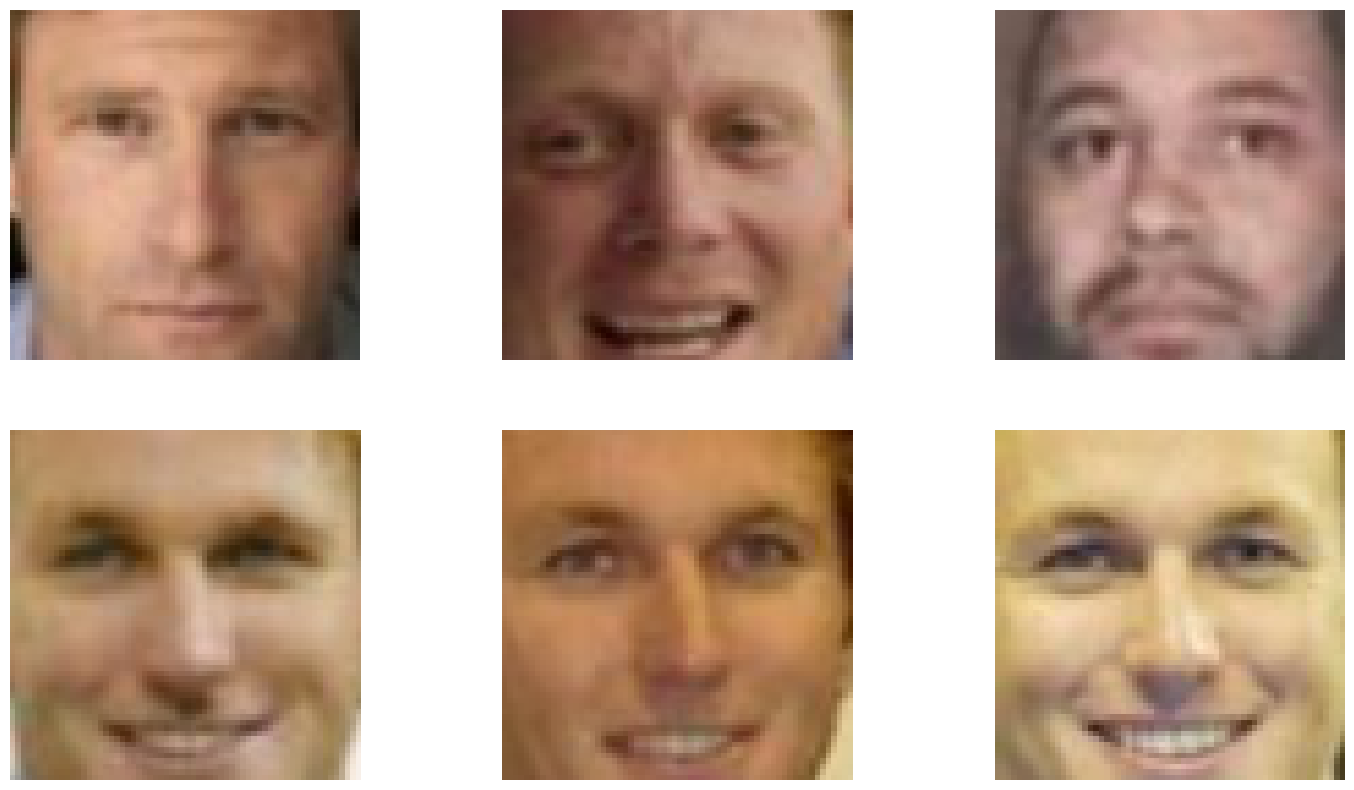

In [ ]:
plt.figure(figsize=(18, 10))
for i, img in enumerate(train_photos[:6]):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(img)

## Изображения в Tensor. Train и Val DataLoader.
### Переводим из numpy array в torch, при этом изменяем порядок размерности. После чего загружаем в DataLoader и дропаем неполные батчи.

In [ ]:
X_train_t =  torch.permute(torch.tensor(train_photos, dtype=torch.float32), (0, 3, 1, 2)) 
X_val_t =  torch.permute(torch.tensor(val_photos, dtype=torch.float32), (0, 3, 1, 2))

train_loader = torch.utils.data.DataLoader(X_train_t, batch_size=128, drop_last=True)
val_loader = torch.utils.data.DataLoader(X_val_t, batch_size=128, drop_last=True)

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 16

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

<hr>
<h2>Будет реализовано 2-е модели:</h2>
<ol>
  <li><h4>Conv, flatten, fully-connected</h4></li>
  <li><h4>Conv (From decoder we add output_pad)</h4></li>
</ol>
<hr>

Desc: Модели поделены на Enc (Encoder) и Dec (Decoder) для сэмплинга в будущем.

In [ ]:
# 1-st model 
class Enc_Autoencoder1(nn.Module):
    def __init__(self):
        super(Enc_Autoencoder1, self).__init__()

        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(True),
            nn.Linear(128, 32)
        )

    def forward(self, x):
      
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        latent_code = self.encoder_lin(x)
        
        return latent_code

class Dec_Autoencoder1(nn.Module):
    def __init__(self):
        super(Dec_Autoencoder1, self).__init__()

        # Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 8 * 8),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 8, 8))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 
            stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, 
            padding=1, output_padding=1))

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction


In [ ]:
# 2-st model 
class Enc_Autoencoder2(nn.Module):
    def __init__(self):
        super(Enc_Autoencoder2, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 7),
        )

    def forward(self, x):
        return self.encoder(x)

class Dec_Autoencoder2(nn.Module):
    def __init__(self):
        super(Dec_Autoencoder2, self).__init__()
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder(x)
        reconstruction = torch.sigmoid(x)

        return reconstruction

In [ ]:
criterion = F.mse_loss

encoder_1st = Enc_Autoencoder1()
decoder_1st = Dec_Autoencoder1()

encoder_2nd = Enc_Autoencoder2()
decoder_2nd = Dec_Autoencoder2()

if torch.cuda.is_available():
    encoder_1st.cuda()
    decoder_1st.cuda()

    encoder_2nd.cuda()
    decoder_2nd.cuda()

parameters_1st = [
        {'params': encoder_1st.parameters()},
        {'params': decoder_1st.parameters()}
    ]
    
parameters_2nd = [
        {'params': encoder_2nd.parameters()},
        {'params': decoder_2nd.parameters()}
    ]

optimizer_1st = torch.optim.Adam(parameters_1st, lr=0.001, weight_decay=1e-04)
optimizer_2nd = torch.optim.Adam(parameters_2nd, lr=0.001, weight_decay=1e-04)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train_auto(encoder, decoder, optimizer, loss_fn, epochs, train_loader, val_loader):
    best_val_loss = None
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        
        encoder.train()
        decoder.train()
        running_train_loss = 0.0
        
        for i, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            latent_code = encoder(X_batch.to(device))
            reconstructed = decoder(latent_code)
            loss = loss_fn(reconstructed, X_batch.to(device))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * X_batch.size(0)
            
        train_losses.append(running_train_loss / len(train_loader))
        
        encoder.eval()
        decoder.eval()
        running_val_loss = 0.0

        for X_batch_val in val_loader:
            latent_code_val = encoder(X_batch_val.to(device))
            reconstructed_val = decoder(latent_code_val)
            loss_val = loss_fn(reconstructed_val, X_batch_val.to(device))
            running_val_loss += loss_val.item() * X_batch_val.size(0)

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(running_val_loss / len(val_loader))

        print('Train loss {:.4f}, Validation loss {:.4f}'.format(running_train_loss / len(train_loader), running_val_loss / len(val_loader)))
        time.sleep(1)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5)) 
        for k in range(5):
            plt.subplot(2, 5, k+1)
            plt.imshow(np.rollaxis(X_batch_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real', fontsize=12)          
            plt.axis('off')

            plt.subplot(2, 5, k+6)
            plt.imshow(np.rollaxis(reconstructed_val[k].detach().cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Generated', fontsize=12)
            plt.axis('off')
                       
        plt.show()
        
        if best_val_loss is None:
            best_val_loss = epoch_val_loss
        elif epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            
    plt.title('Train/val losses during training process')
    plt.plot(np.arange(epochs), train_losses, label='train')
    plt.plot(np.arange(epochs), val_losses, label='val')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    print('Best valid loss', best_val_loss)
    return encoder, decoder, train_losses, val_losses

## Для начала обучим первую модель.
<hr>

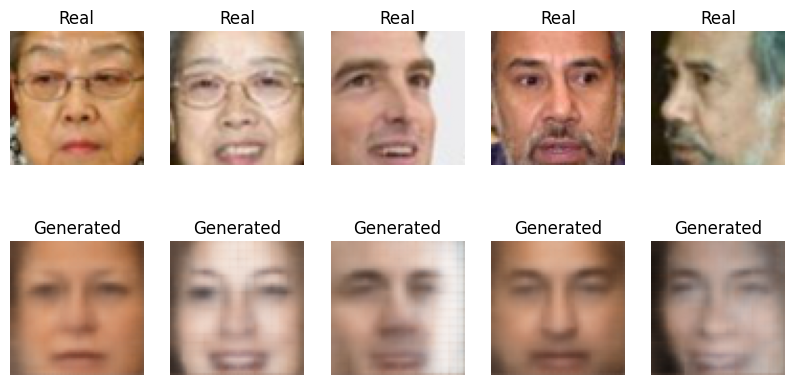

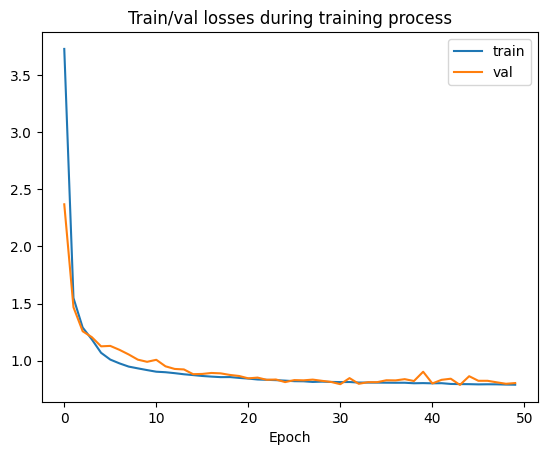

Best valid loss 0.7878268361091614
CPU times: user 1min 27s, sys: 5.45 s, total: 1min 32s
Wall time: 2min 25s


In [ ]:
%%time
trainde_encoder_1st, trainde_decoder_1st, train_loss_1st, val_loss_1st = train_auto(encoder_1st, decoder_1st, optimizer_1st, criterion, 50, train_loader, val_loader)

## Теперь обучим вторую модель.
<hr>

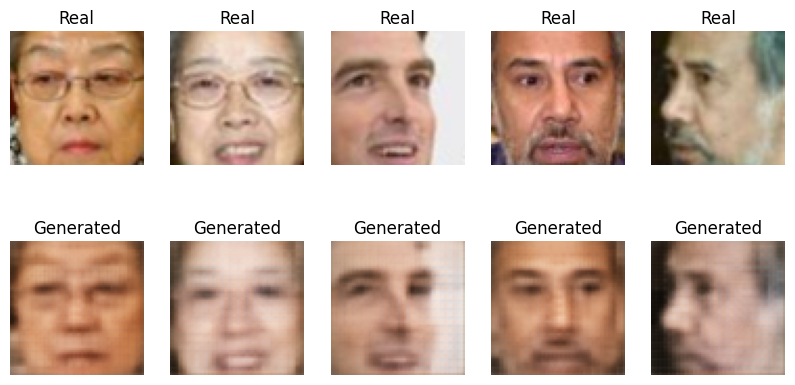

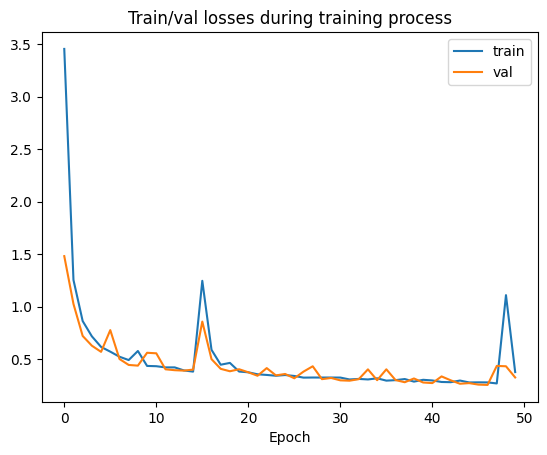

Best valid loss 0.2532485261559486
CPU times: user 1min 26s, sys: 5.31 s, total: 1min 32s
Wall time: 2min 17s


In [ ]:
%%time
trainde_encoder_2nd, trainde_decoder_2nd, train_loss_2nd, val_loss_2nd = train_auto(encoder_2nd, decoder_2nd, optimizer_2nd, criterion, 50, train_loader, val_loader)

<hr>

#### Desc: Обе модели обучались приблизительно одинаковое время, но как мы видим 2-я модель имеет loss в 3-и раза меньше чем 1-я модель.
<hr>


Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
def eval_and_plot(encoder, decoder, val_loader):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch in val_loader:
            latent_val = encoder(batch.to(device))
            reconstracted = decoder(latent_val)
            reconstruction = np.rollaxis(reconstracted.detach().cpu().numpy(), 1, 4)
            ground_truth = np.rollaxis(batch.numpy(), 1, 4)
            break
        
    plt.figure(figsize=(10, 5))
    for i, (gt, res) in enumerate(zip(ground_truth[:5], reconstruction[:5])):
        plt.subplot(2, 5, i+1)
        plt.imshow(gt)
        plt.grid(None)
        plt.axis('off')
    
        plt.subplot(2, 5, i+6)
        plt.imshow(res)
        plt.grid(None)
        plt.axis('off')

## 1-st Model
<hr>

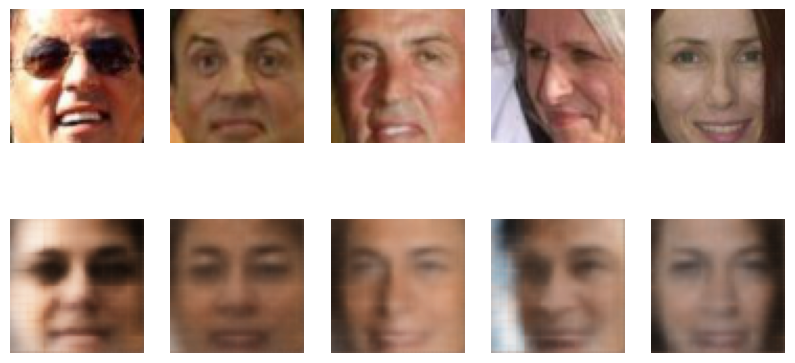

In [ ]:
eval_and_plot(trainde_encoder_1st, trainde_decoder_1st, val_loader)

##2-nd Model
<hr>

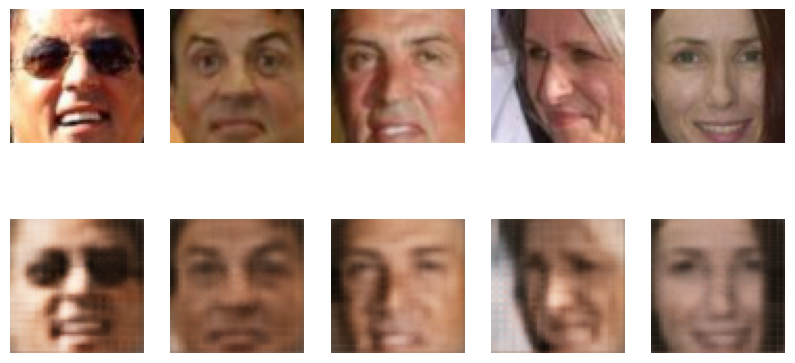

In [ ]:
eval_and_plot(trainde_encoder_2nd, trainde_decoder_2nd, val_loader)

Not bad, right? <br>
Ye, the results are pretty good!

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

<h3>Для начала получим латентные векторы. Будем использовать 2-ю модель как наилучшую.</h3>
<hr>
Desc: Здесь как раз нам и прегодится разделение на энкодер и декодер

In [ ]:
def get_latent_vector(data):
  latent_vecs = []
  with torch.no_grad():
      for batch in data:
          batch = batch[None,:,:,:]
          latent_val = trainde_encoder_2nd(batch.to(device))
          latent_vecs.append(latent_val)

  res_latent = torch.cat(latent_vecs, dim=0)
  return res_latent     

In [ ]:
res_latent = get_latent_vector(X_train_t)
print(res_latent.shape)

torch.Size([11828, 64, 10, 10])


<h3>Теперь нам необходимо получить 'mean' и 'std' нашего латентного слоя.</h3>

In [ ]:
mean_lat = torch.mean(res_latent, dim=0)
std_lat = torch.std(res_latent, dim=0)

<h3>Теперь генерируем 25 рандомных векторов размера latent_space.</h3>

In [ ]:
random_vec = torch.FloatTensor(np.random.randn(25, *(64, 10, 10)))
z = mean_lat + std_lat*random_vec.to(device)

print(z.shape)

torch.Size([25, 64, 10, 10])


<h3>Скармливаем получившиеся векторы нашему декодеру</h3>

In [ ]:
output = trainde_decoder_2nd(z)

<hr>
<h3>Выводим получившийся результат:</h3>
<hr>

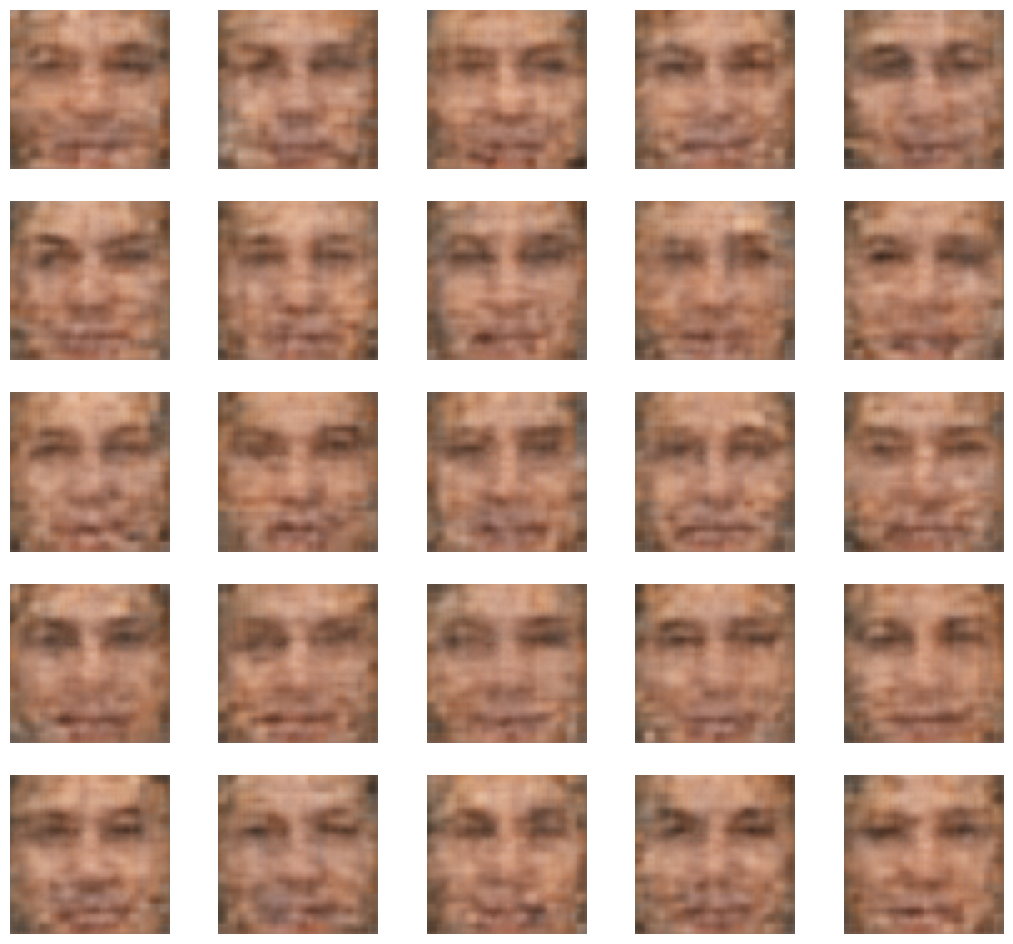

In [ ]:
plt.figure(figsize=(13, 12))
for i in range(output.shape[0]):
    plt.subplot(output.shape[0] // 5, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.axis('off')
    plt.imshow(np.rollaxis(generated, 0, 3))

plt.show()

Desc: в результате как мы видим мы получили не абы что, а некие подобия лиц.

## 1.5 Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

<hr>
<h3>Для начала изучу весь список классов</h3>

In [ ]:
for i, col in enumerate(attrs):
    print(f"[{i}]: {col}")

[0]: Male
[1]: Asian
[2]: White
[3]: Black
[4]: Baby
[5]: Child
[6]: Youth
[7]: Middle Aged
[8]: Senior
[9]: Black Hair
[10]: Blond Hair
[11]: Brown Hair
[12]: Bald
[13]: No Eyewear
[14]: Eyeglasses
[15]: Sunglasses
[16]: Mustache
[17]: Smiling
[18]: Frowning
[19]: Chubby
[20]: Blurry
[21]: Harsh Lighting
[22]: Flash
[23]: Soft Lighting
[24]: Outdoor
[25]: Curly Hair
[26]: Wavy Hair
[27]: Straight Hair
[28]: Receding Hairline
[29]: Bangs
[30]: Sideburns
[31]: Fully Visible Forehead
[32]: Partially Visible Forehead
[33]: Obstructed Forehead
[34]: Bushy Eyebrows
[35]: Arched Eyebrows
[36]: Narrow Eyes
[37]: Eyes Open
[38]: Big Nose
[39]: Pointy Nose
[40]: Big Lips
[41]: Mouth Closed
[42]: Mouth Slightly Open
[43]: Mouth Wide Open
[44]: Teeth Not Visible
[45]: No Beard
[46]: Goatee
[47]: Round Jaw
[48]: Double Chin
[49]: Wearing Hat
[50]: Oval Face
[51]: Square Face
[52]: Round Face
[53]: Color Photo
[54]: Posed Photo
[55]: Attractive Man
[56]: Attractive Woman
[57]: Indian
[58]: Gray Hai

<h3>Нашел 2-а подходящих класса: '<b>Smiling</b>' и '<b>Frowning</b>'</h3>
<hr>
<h4>Получу 20-ть картинок связанные с этими классами</h4>

In [ ]:
smile_data = attrs[attrs['Smiling'] > 1].index
smile_data = np.random.choice(smile_data,20)

sad_data = attrs[attrs['Frowning'] > 1].index
sad_data = np.random.choice(sad_data,20)

<h3>Выведем полученные изображения</h3>
<hr>

In [ ]:
def plot_people(samples, title):
    plt.figure(figsize=(12, 12))
    for i, gt in enumerate(data[samples]):
        plt.subplot(4, 5, i+1)
        plt.title(title, fontsize=10)
        plt.axis('off')
        plt.imshow(gt)

(None, None)

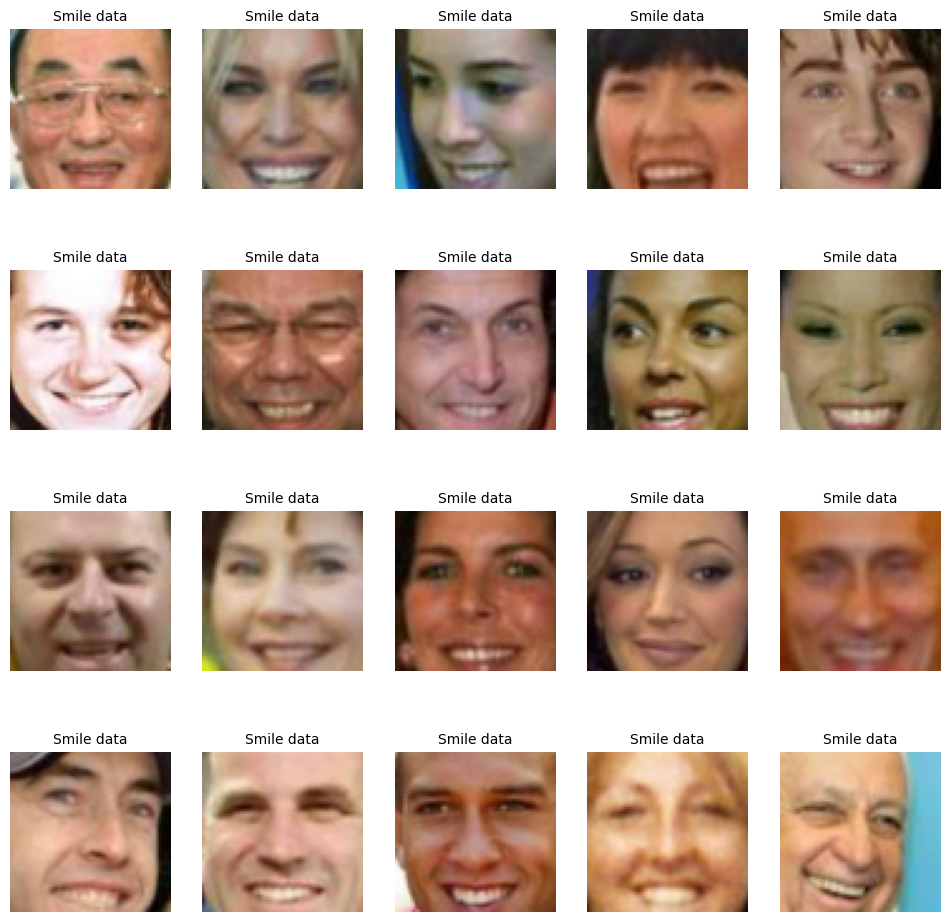

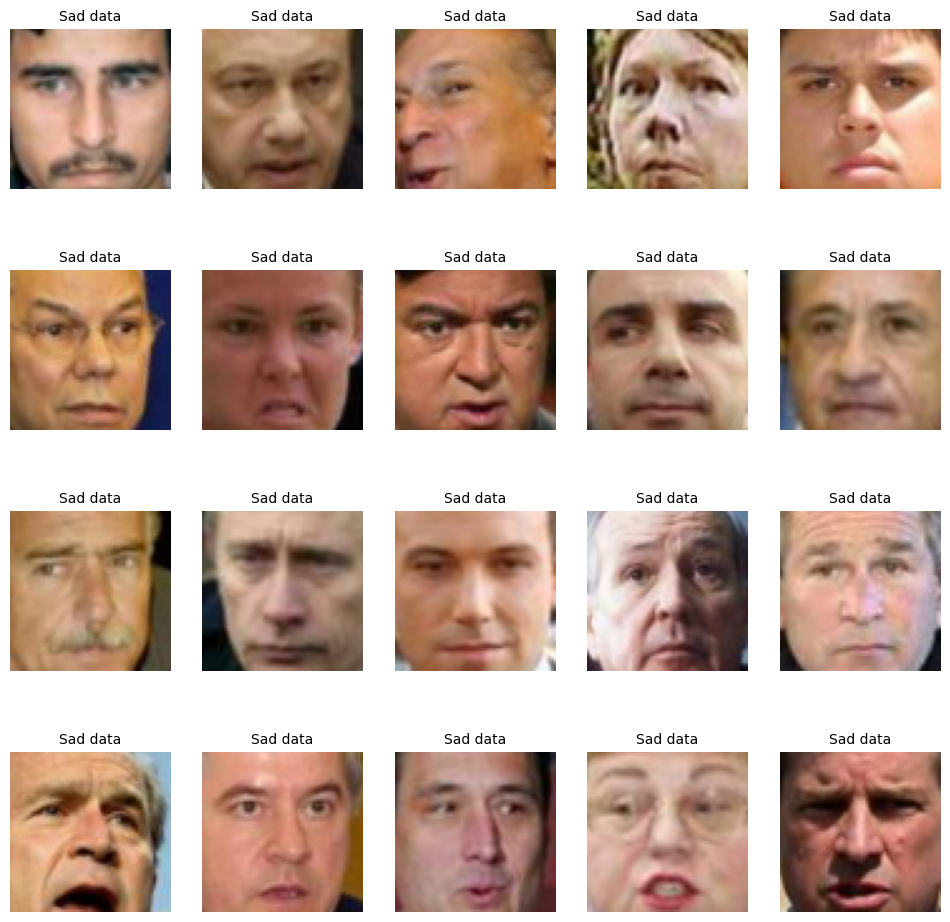

In [ ]:
plot_people(smile_data, "Smile data"), plot_people(sad_data, "Sad data")

<h3>Вычислим вектор улыбки и попробуем добавить его к грусным лицам</h3>
<hr>

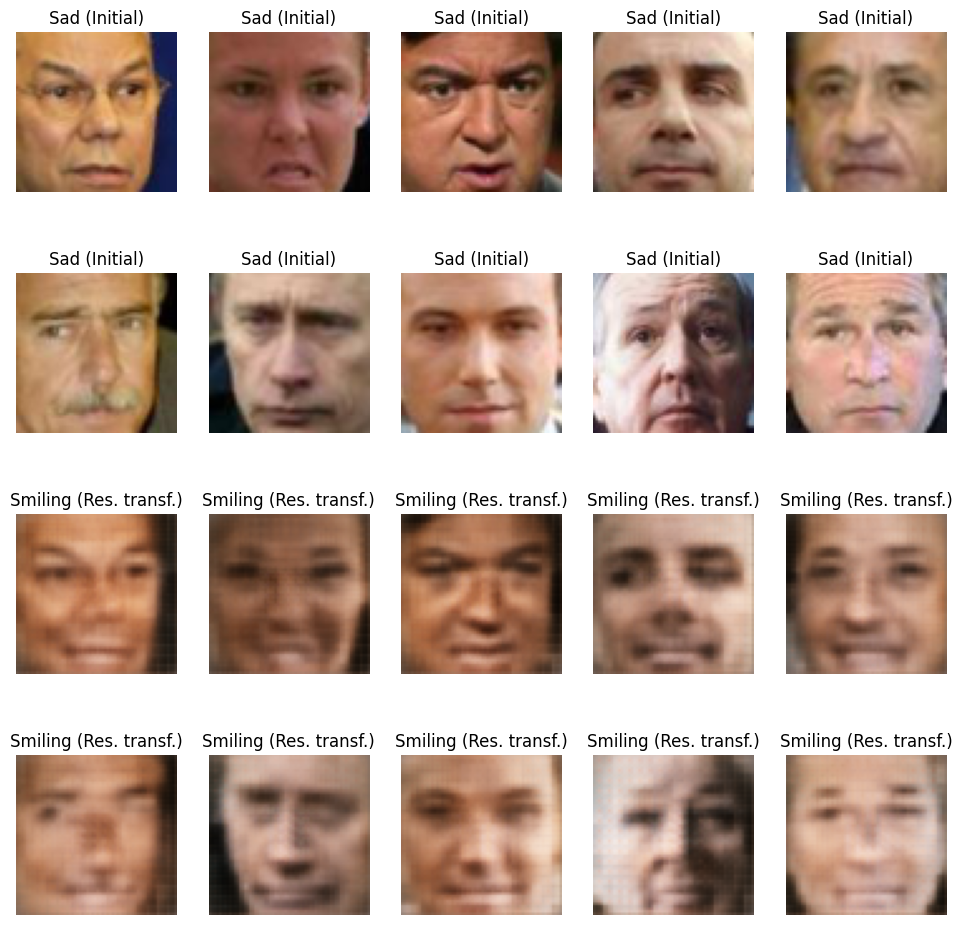

In [ ]:
# Получаем тензор из numpy array data
data_smily =  torch.permute(torch.tensor(data[smile_data], dtype=torch.float32), (0, 3, 1, 2))
data_sadness = torch.permute(torch.tensor(data[sad_data], dtype=torch.float32), (0, 3, 1, 2))

# Получаем латентные вектора грустного и улыбающегося датасета
lat_vec_smile = get_latent_vector(data_smily)
lat_vec_sad = get_latent_vector(data_sadness)

# Получаем среднее и отклонение для обоих латентных векторов
mean_lat_smile = torch.mean(lat_vec_smile, dim=0)
std_lat_smile = torch.std(lat_vec_smile, dim=0)

mean_lat_sad = torch.mean(lat_vec_sad, dim=0)
std_lat_sad = torch.std(lat_vec_sad, dim=0)

# Вычитаем из улибки грустный вектор
difference = mean_lat_smile - mean_lat_sad

# Получаем вектор улыбки
result = lat_vec_sad + difference

# Передаём декодеру наш вектор
output_res = trainde_decoder_2nd(result.to(device))

# Проводим расчеты для получения результата
output_numpy = np.rollaxis(output_res.cpu().detach().numpy(), 1, 4)
data_sad_numpy = np.rollaxis(data_sadness.cpu().detach().numpy(), 1, 4)

plt.figure(figsize=(12, 12))
for i, (gt, res) in enumerate(zip(output_numpy[5:15], data_sad_numpy[5:15])):
    plt.subplot(4, 5, i + 1)
    plt.imshow(res)
    plt.axis('off')
    plt.title('Sad (Initial)')

    plt.subplot(4, 5, i + 11)
    plt.imshow(gt)
    plt.axis('off')
    plt.title('Smiling (Res. transf.)')
    
plt.show()

Вуаля! Вы восхитительны!
<br>
Thx.

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [3]:
batch_size = 32

data_transforms = transforms.Compose([
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.RandomCrop(size=28, padding=2),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# # MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=data_transforms, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=data_transforms, download=False)

# # Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

<hr>
<h3>Была реализована простая модель VAE, которая в ходе обучения будет возвращать mu, logsigma, reconstruction</h3>
<hr>

In [4]:
class VAE_Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Encoder, self).__init__()

        self.encode = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=128 * 7 * 7, out_features=512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features=2 * latent_dim))

    def reparameterize(self, mu, logsigma):
        std = logsigma.exp()
        eps = torch.randn_like(std)
        sample = mu + eps * std

        return sample

    def forward(self, x):
        x = self.encode(x)
        x = x.view(-1, 128 * 7 * 7)

        x = self.linear(x)
        mu, logsigma = torch.chunk(x, 2, dim=1)

        reparameterized = self.reparameterize(mu, logsigma)
        return mu, logsigma, reparameterized

class VAE_Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_Decoder, self).__init__()

        self.unlinear = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(in_features=512, out_features=128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1))

    def forward(self, x):
        x = self.unlinear(x)
        x = x.view(-1, 128, 7, 7)

        x = self.decoder(x)
        
        return x

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

<hr>
<h4>Для этой реализации можно вспомнить лекцию</h4>
<hr>

In [5]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss 

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [6]:
criterion = loss_vae

latent_dim = 20

vae_encoder = VAE_Encoder(latent_dim)
vae_decoder = VAE_Decoder(latent_dim)

if torch.cuda.is_available():
    vae_encoder.cuda()
    vae_decoder.cuda()

optimizer = torch.optim.Adam(list(vae_encoder.parameters()) + list(vae_decoder.parameters()), lr=0.001, weight_decay=1e-04)

<hr>
<h3>Саму функцию обучения необходимо слега модернизировать, т.к. у нас уже другая loss_function и другая модель. Для этого изучим возвращаемые параметры модели и нужные параметры для loss_function</h3>

In [7]:
def train_VAE(vae_enc, vae_dec, optimizer, loss_fn, epochs, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):

        vae_enc.train()
        vae_dec.train()
        train_losses_per_epoch = []
        
        for batch, _ in train_loader:
            optimizer.zero_grad()
            
            mu, logsigma, reparameterized = vae_enc(batch.to(device))
            recon_x = vae_dec(reparameterized)
            
            loss = loss_fn(batch.to(device), mu, logsigma, torch.sigmoid(recon_x))
            
            loss.backward()
            optimizer.step()
            
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        
        vae_enc.eval()
        vae_dec.eval()

        val_losses_per_epoch = []

        with torch.no_grad():
            for X_batch_val, _ in val_loader:
              
                mu_val, logsigma_val, reparameterized_val = vae_enc(X_batch_val.to(device))
                recon_x_val = vae_dec(reparameterized_val)
                loss_val = loss_fn(X_batch_val.to(device), mu_val, logsigma_val, torch.sigmoid(recon_x_val))

                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return vae_enc, vae_dec, train_losses, val_losses

<hr>
<h4>После модернизации процесса обучения можно приступать к <b>Обучению</b> нашей модели VAE</h4>
<hr>

In [8]:
trainde_vae_enc, trainde_vae_dec, vae_train_loss, vae_val_loss = train_VAE(vae_encoder, vae_decoder, optimizer, criterion, 10, train_loader, test_loader)

  0%|          | 0/10 [00:00<?, ?it/s]

Desc: Можно так же ради эксперимета вывести получившиеся значения loss на валидации и трейне, но что-то особенно здесь увидеть не получится, поэтому как такового смысла это выводить не было.

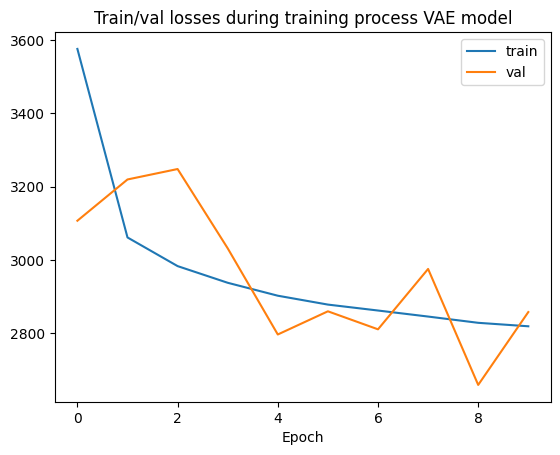

In [9]:
plt.title('Train/val losses during training process VAE model')
plt.plot(np.arange(10), vae_train_loss, label='train')
plt.plot(np.arange(10), vae_val_loss, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [10]:
print("Best min. val. loss: {}".format(min(vae_val_loss)))

Best min. val. loss: 2659.501953125


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

<hr>
<h3>Аналогично предыдущему разу провалидируем на тестовой выборке и посмотрим на результат</h3>

In [14]:
def VAE_eval_plot(vae_enc, vae_dec, test):

    vae_enc.eval()
    vae_dec.eval()
    with torch.no_grad():
          for batch, _ in test:
            
            mu, logsigma, reparameterized = vae_enc(batch.to(device))
            recon_x = vae_dec(reparameterized)

            recon_x = np.rollaxis(torch.sigmoid(recon_x).detach().cpu().numpy(), 1, 4)
            ground_truth = np.rollaxis(batch.numpy(), 1, 4)
            break

    plt.figure(figsize=(24, 8))
    for i, (gt, res) in enumerate(zip(ground_truth[:10], recon_x[:10])):
        
        plt.subplot(2, 10, i+1)
        plt.imshow(np.squeeze(gt))
        plt.grid(None)
        plt.title("Ground truth")
        plt.axis('off')

        plt.subplot(2, 10, i+11)
        plt.imshow(np.squeeze(res))
        plt.grid(None)
        plt.title("Reconstruction")
        plt.axis('off')

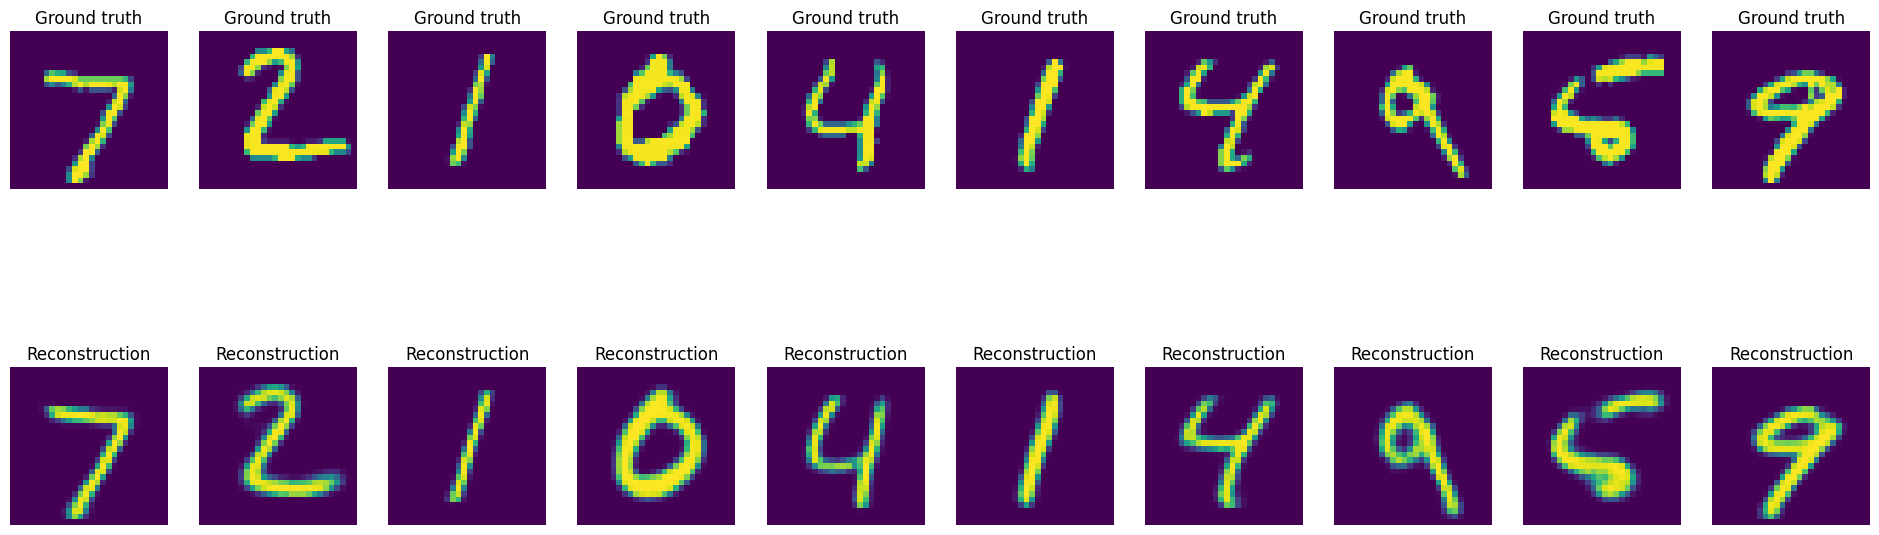

In [15]:
VAE_eval_plot(trainde_vae_enc, trainde_vae_dec, test_loader)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [16]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = torch.FloatTensor(np.array([np.random.normal(0, 1, 20) for i in range(10)]))

<h3>Почти аналогично предыдущему разу мы получаем с энкодера вектор средних значений далее будем считать отклонение и среднее, после чего просемплируем, пропустим через декодер и получим результат <i>Изображения</i> в output</h3>

In [42]:
mu_vec = []

# Получаем mu после энкодинга у нашего vae
with torch.no_grad():
    for batch, _ in test_loader:
        mu, _, _ = trainde_vae_enc(batch.to(device))
        
        mu_vec.append(mu)

# Объединяем все в один вектор
mean_vec = torch.cat(mu_vec, dim=0)
std_vec = torch.exp(torch.cat(mu_vec, dim=0))

# Высчитываем среднее и отклонение
mean = torch.mean(mean_vec, dim=0)
std = torch.std(std_vec, dim=0)

# Сэмплируем наши значения
sample = z.to(device) * std + mean

# Пропускаем sample через декодер
output = torch.sigmoid(trainde_vae_dec(sample))

<h4>Выводим нашь результат операций над случайным вектором из нормального распределения.</h4>

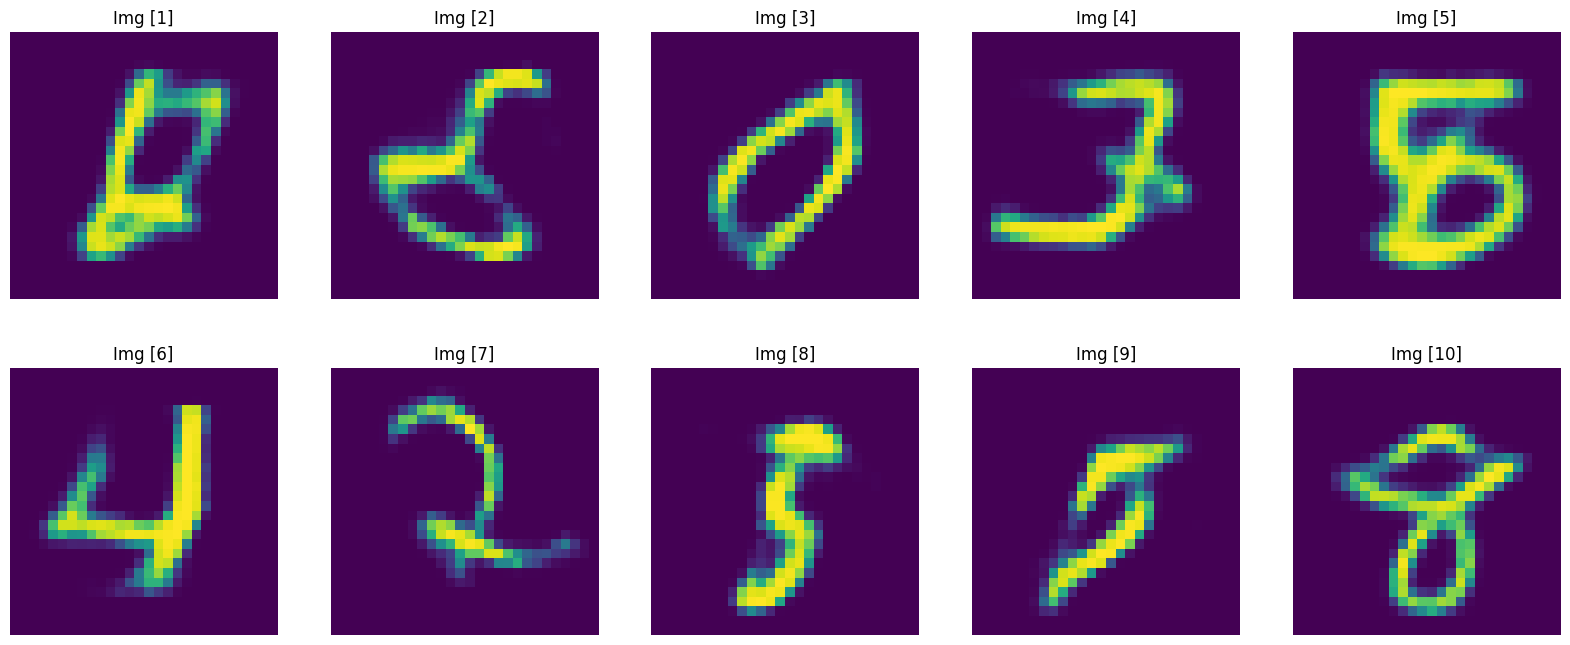

In [43]:
plt.figure(figsize=(20, 8))
for i in range(output.shape[0]):
    plt.subplot(2,output.shape[0] // 2, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.axis('off')
    plt.title(f"Img [{i+1}]")
    plt.imshow(np.squeeze(generated))
    
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

<hr>
<h3>Для начала выпоним 1-й пункт из нашего плана, для этого получим латентные вектора, развернём их и будем добавлять в samples. После чего добавим этот список в pandas DataFrame</h3>

In [44]:
samples = []

for img, label in test_dataset:
    # Encode image
    trainde_vae_enc.eval()
    with torch.no_grad():
        img = img.view(1, 1, 28, 28)
        _, _, encoded_img  = trainde_vae_enc.forward(img.to(device))

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  
    encoded_sample['label'] = label
    samples.append(encoded_sample)

encoded_samples = pd.DataFrame(samples)

<h4>Далее согласно 2-му пункту при помощи TSNE сожмём данные представления. Для этого инициализируем объект данного класса (n_components=2 по дефолту установлено в 2-а) и используем метод fit_transform для его преобразования (обычный фит не возвращает нам этого представления)</h4>

In [45]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

<h4>Реализуем пункт 3-и и выведем при помощи plt.scatter полученный результат</h4> 

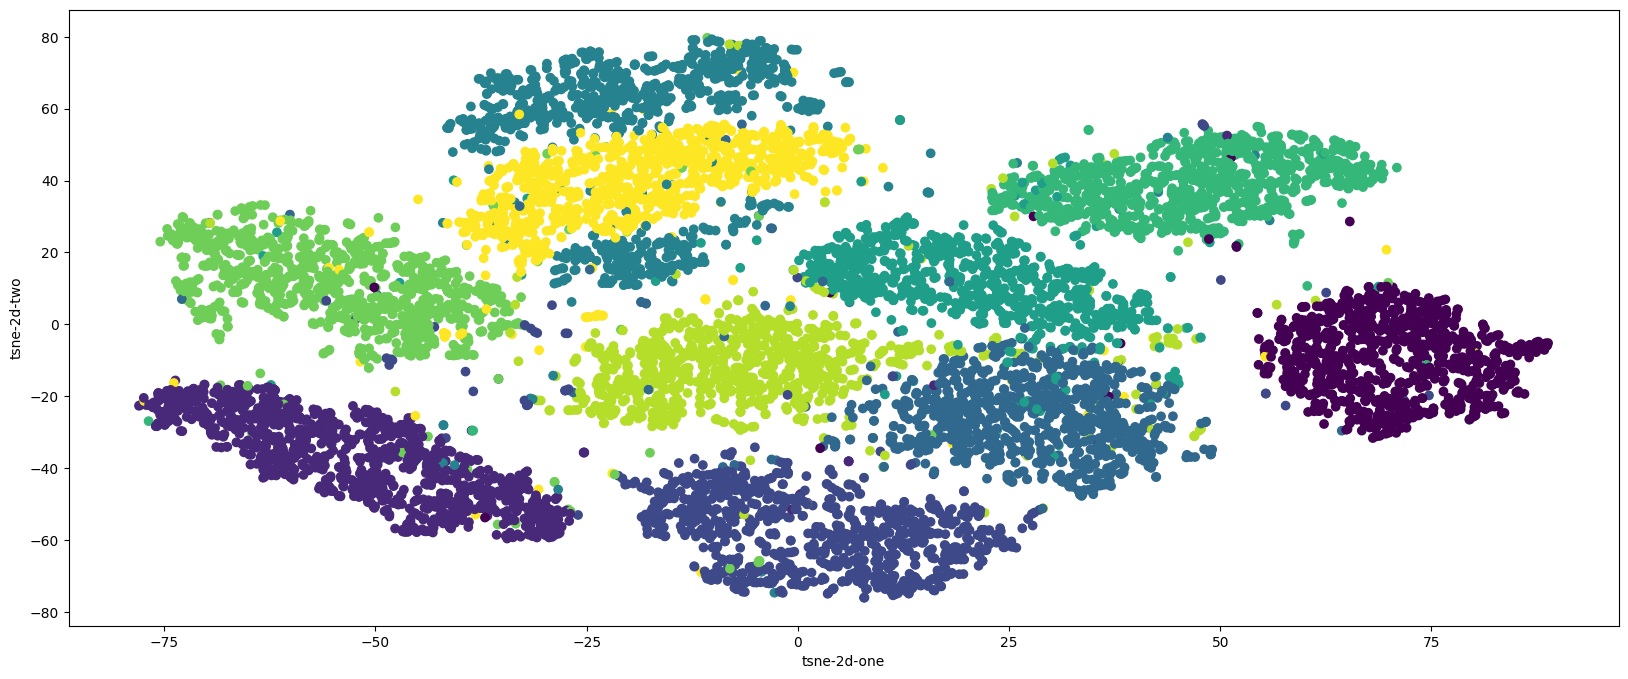

In [46]:
x = []
y = []

for x_val, y_val in tsne_results:
  x.append(x_val)
  y.append(y_val)

plt.figure(figsize=(20, 8))

plt.scatter(x, y, c = encoded_samples.label)

plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")

plt.show()

Что вы думаете о виде латентного представления?<br>По данному изображению можно видеть, что наши латентные вектора распрделены достаточно разбросанно (точнее они сгруппированны и между ними присутствуют промежутки) 👍

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
features = 16

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.flatten = nn.Flatten()

        # Отличие от VAE только в том что на входе у нас будет +10 in_features в encoder и decoder (10 классов)
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=794, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=features*2)
        )

        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=features + 10, out_features=392),
            nn.ReLU(),
            nn.Linear(in_features=392, out_features=784)
        )

    def encode(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)

        mu = x[:, 0, :]
        logsigma = x[:, 1, :]

        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            sample = self.reparameterize(mu, logsigma)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)  # standard deviation
        eps = torch.randn_like(std)     # `randn_like` as we need the same size
        sample = mu + (eps * std)       # sampling as if coming from the input space
        return sample
    
    def decode(self, z, class_num):
        z_concatened = torch.cat([z, class_num], 1)        
        z = self.decoder(z_concatened)
        reconstruction = torch.sigmoid(z)

        return reconstruction

    def forward(self, x, class_num):
        # Encoding
        x = self.flatten(x).float()
        mu, logsigma, class_num = self.encode(x, class_num)

        # Decoding
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, class_num)
        return mu, logsigma, reconstruction 
    
    def get_latent_vector(self, x, class_num):
        x = self.flatten(x).float()
        x_concatened = torch.cat([x, class_num], 1)
        x = self.encoder(x_concatened).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.gaussian_sampler(mu, log_var)
        return z

<hr>
<h4>Сама модель у нас реализована, теперь давайте обучим её, но для начала необходимо вопервых переделать сам процесс обучения, а так же можно заметить что y наши классы преобразуются при помощи One-hot encoding'а, поэтому нам так же необхоимо написать функцию для One-hot</h4>
<hr>

In [ ]:
# Реализуем One-hot
def One_hot(class_size, labels):

    # создаем тензор из нулей размером labels.size(0) x class_size
    targets = torch.zeros(labels.size(0), class_size)
    
    # заполняем тензор
    for i, label in enumerate(labels):
        targets[i, label] = 1
  
    return Variable(targets)

Замечу, мы могли импортировать One-hot:
<i>from sklearn.preprocessing import OneHotEncoder</i><br>
Так же ссылка на объяснение на счёт [Variable](https://ru.stackoverflow.com/questions/1251165/%D0%A7%D1%82%D0%BE-%D0%B8-%D0%B7%D0%B0%D1%87%D0%B5%D0%BC-%D0%BA%D0%BB%D0%B0%D1%81%D1%81-variable-pytorch).
<hr>

<h3>Теперь подготовим модель и все данные к обучению</h3>


In [ ]:
criterion = loss_vae
one_hot_enc = One_hot

cvae_autoencoder = CVAE()

if torch.cuda.is_available():
    cvae_autoencoder.cuda()

cond_dim = train_loader.dataset.train_labels.unique().size(0)

optimizer = torch.optim.Adam(cvae_autoencoder.parameters(), lr=0.001, weight_decay=1e-04)

<hr>
<h3>Теперь напишем функцию обучения нашей модели</h3>

In [ ]:
def train_CVAE(cvae, optimizer, loss_fn, one_hot_fn, epochs, cond_dim, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(epochs)):

        cvae.train()
        train_losses_per_epoch = []
        
        for batch, cond in train_loader:
            cond = one_hot_fn(cond_dim, cond)
            optimizer.zero_grad()
            mu, logsigma, reconstruction = cvae(batch.to(device), cond.to(device))
            reconstruction = reconstruction.view(-1, 1, 28, 28)
            loss = loss_fn(batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        
        cvae.eval()
        val_losses_per_epoch = []

        with torch.no_grad():
            for X_batch_val, cond in val_loader:
                cond = one_hot_fn(cond_dim, cond)
                mu_val, logsigma_val, reconstruction_val = cvae(X_batch_val.to(device), cond.to(device))
                reconstruction_val = reconstruction_val.view(-1, 1, 28, 28)
                loss_val = loss_fn(X_batch_val.to(device).float(), mu_val, logsigma_val, reconstruction_val)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))

    return cvae, train_losses, val_losses

<h3>Функция обучения модели реализована! Теперь приступим к самому интересному - <b>Обучению</b></h3>

In [ ]:
trainde_сvae, сvae_train_loss, сvae_val_loss = train_CVAE(cvae_autoencoder, optimizer, criterion, one_hot_enc, 50, cond_dim, train_loader, test_loader)

  0%|          | 0/50 [00:00<?, ?it/s]

Desc: Как и в случае с VAE я вывел график лосс. Но как такового смсыла он особого не имеет.

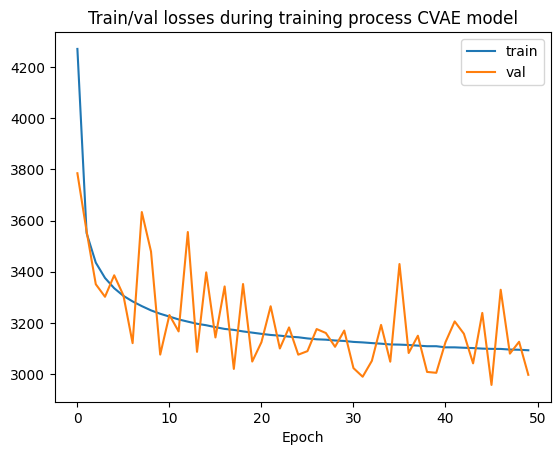

In [ ]:
plt.title('Train/val losses during training process CVAE model')
plt.plot(np.arange(50), сvae_train_loss, label='train')
plt.plot(np.arange(50), сvae_val_loss, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
z = torch.FloatTensor(np.array([np.random.normal(0, 1, 16) for i in range(1)])) # генерируем случайный вектор

<hr>
<h3>Здесь так же все практически аналогично модели VAE, за исключением подачи на декодер</h3>

In [ ]:
mu_vecs = []
with torch.no_grad():
    for img, cond in test_loader:
        cond = One_hot(cond_dim, cond)
        mu, _, _ = trainde_сvae.encode(img.to(device), cond.to(device))
        mu_vecs.append(mu)

# Объединяем все в один вектор
mean_vecs = torch.cat(mu_vecs, dim=0)
std_vecs = torch.exp(0.5 * torch.cat(mu_vecs, dim=0))

# Высчитываем среднее и отклонение
mean = torch.mean(mean_vecs, dim=0)
std = torch.std(std_vecs, dim=0)

# Сэмплируем наши значения
sample = z.to(device) * std + mean

arr_dec_num = [5, 7]
output = [None] * len(arr_dec_num)

for i, num in enumerate(arr_dec_num):
    # Подготовим число, которое мы ходим получить
    num_hot = One_hot(cond_dim ,torch.LongTensor([num])).to(device)

    # Пропускаем sample через декодер
    reconstruction = trainde_сvae.decode(sample, num_hot)

    # Не забываем преобразовать в формат изображения для вывода
    resulted = nn.Unflatten(dim=1, unflattened_size=(28,28,1))
    output[i] = resulted(reconstruction)

<hr>
<h3>Давайте теперь выведем на экран получившиеся изображения!</h3>

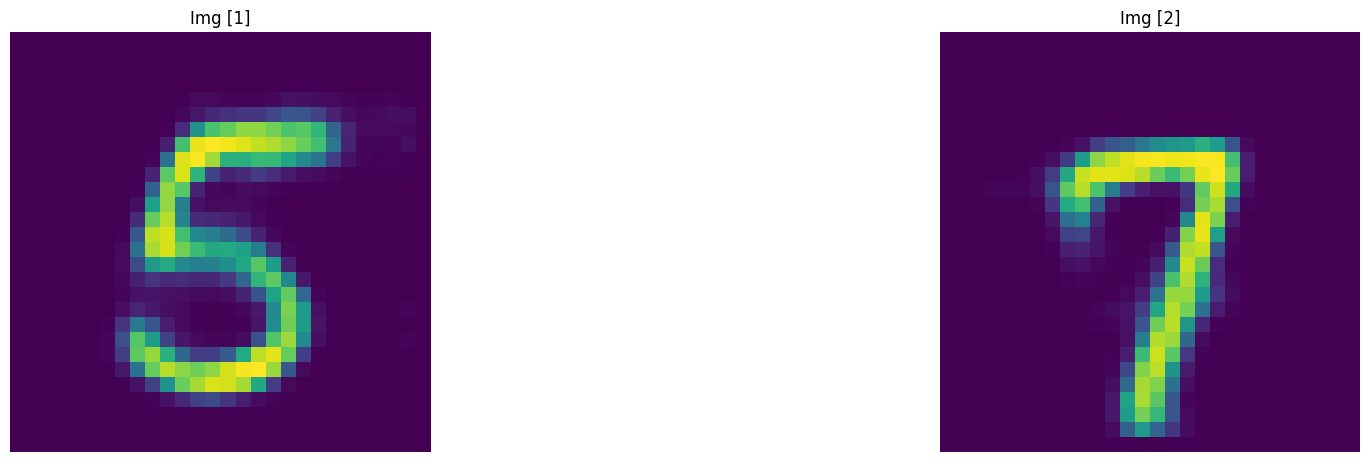

In [ ]:
plt.figure(figsize=(22, 12))
for i in range(len(output)):
    plt.subplot(2, len(output) // 1, i + 1)
    generated = output[i].cpu().detach().numpy()
    plt.axis('off')
    plt.title(f"Img [{i+1}]")
    plt.imshow(np.squeeze(generated))

plt.show()

<h3>Как мы видем результат очень достойный. Мы получили те самые цефры, которые и заказывали!</h3>

p.s: Если хотим вывести все классы цифр на экран, то можно в массиве arr_dec_num их всех перечислить.
<hr>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

<hr>
<h3>Аналогично VAE реализуем по плану 3-х пунктов данное задание</h3>

In [ ]:
samples = []

for img, label in test_dataset:
    # Encode image
    trainde_сvae.eval()
    with torch.no_grad():
        one_hot_res = One_hot(cond_dim, torch.LongTensor([label])).to(device)
        encoded_img  = trainde_сvae.get_latent_vector(img.to(device), one_hot_res)

    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
  
    encoded_sample['label'] = label
    samples.append(encoded_sample)

encoded_samples = pd.DataFrame(samples)

<h4>Теперь TSNE...</h4>

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

<h4>И наконец выводим получившийся результат!</h4>
<hr>

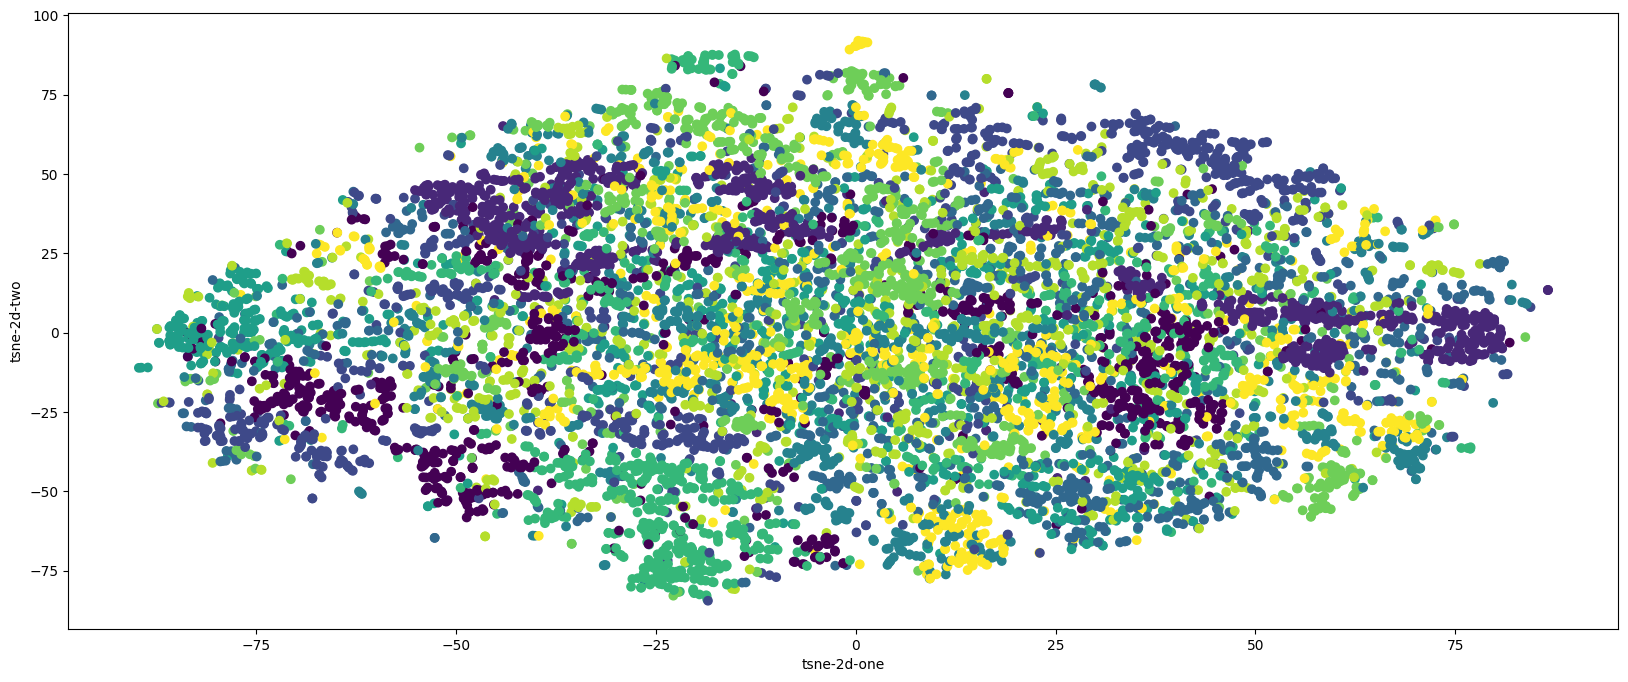

In [ ]:
x = []
y = []

for x_val, y_val in tsne_results:
  x.append(x_val)
  y.append(y_val)

plt.figure(figsize=(20, 8))

plt.scatter(x, y, c = encoded_samples.label)

plt.xlabel("tsne-2d-one")
plt.ylabel("tsne-2d-two")

plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?<br><hr>
<p>Как видно, по самой форме он не очень отличается, а вот распброс и групировка классов отличается. В VAE у нас классы не старались кучковаться и диапазон разброса был меньше (+-42 по осям x,y)<br>А вот в CVAE мы видим, что значения как-то сгруппированы и разброс у них больше почти в 2-а раза (+-80 по осям x,y). Так что, можно сказать, что все же отличия есть.</p>

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>